In [ ]:
!nvidia-smi

Wed Nov 13 22:35:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              40W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

data_dir = '/content/drive/My Drive/Face_Swap_Detection_Face_Edge_Method/train_data'
dataset = datasets.ImageFolder(data_dir, transform=transform)


# Define the split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Load a pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: real and fake

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


In [ ]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Implement learning rate scheduler (optional)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Set up early stopping parameters
early_stopping_patience = 10  # Number of epochs with no improvement after which training will be stopped
best_val_loss = float('inf')
epochs_no_improve = 10

num_epochs = 50  # Increased number of epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)

    val_loss = val_running_loss / val_size
    val_acc = val_running_corrects.double() / val_size
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

     # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

    # Access the current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
    print(f'Current Learning Rate: {current_lr:.6f}')

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model weights
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print('Early stopping triggered')
            break

Epoch 1/50
Train Loss: 0.1378 Acc: 0.9386
Val   Loss: 0.2487 Acc: 0.8916
Epoch 1/50
Train Loss: 0.1378 Acc: 0.9386
Val   Loss: 0.2487 Acc: 0.8916
Current Learning Rate: 0.000125
Epoch 2/50
Train Loss: 0.1201 Acc: 0.9524
Val   Loss: 0.2645 Acc: 0.8896
Epoch 2/50
Train Loss: 0.1201 Acc: 0.9524
Val   Loss: 0.2645 Acc: 0.8896
Current Learning Rate: 0.000125
Epoch 3/50
Train Loss: 0.1118 Acc: 0.9504
Val   Loss: 0.2607 Acc: 0.8885
Epoch 3/50
Train Loss: 0.1118 Acc: 0.9504
Val   Loss: 0.2607 Acc: 0.8885
Current Learning Rate: 0.000063
Epoch 4/50
Train Loss: 0.0995 Acc: 0.9568
Val   Loss: 0.2532 Acc: 0.9090
Epoch 4/50
Train Loss: 0.0995 Acc: 0.9568
Val   Loss: 0.2532 Acc: 0.9090
Current Learning Rate: 0.000063
Epoch 5/50
Train Loss: 0.0980 Acc: 0.9616
Val   Loss: 0.2802 Acc: 0.8957
Epoch 5/50
Train Loss: 0.0980 Acc: 0.9616
Val   Loss: 0.2802 Acc: 0.8957
Current Learning Rate: 0.000031
Epoch 6/50
Train Loss: 0.0926 Acc: 0.9622
Val   Loss: 0.2804 Acc: 0.8957
Epoch 6/50
Train Loss: 0.0926 Acc: 0.

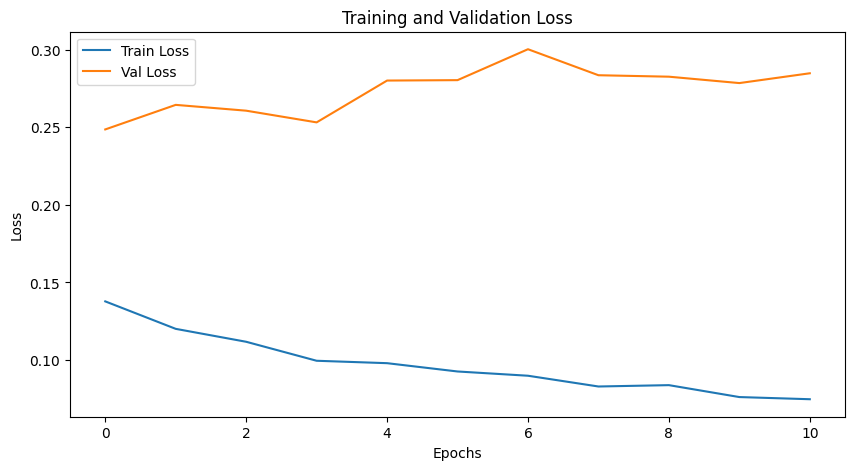

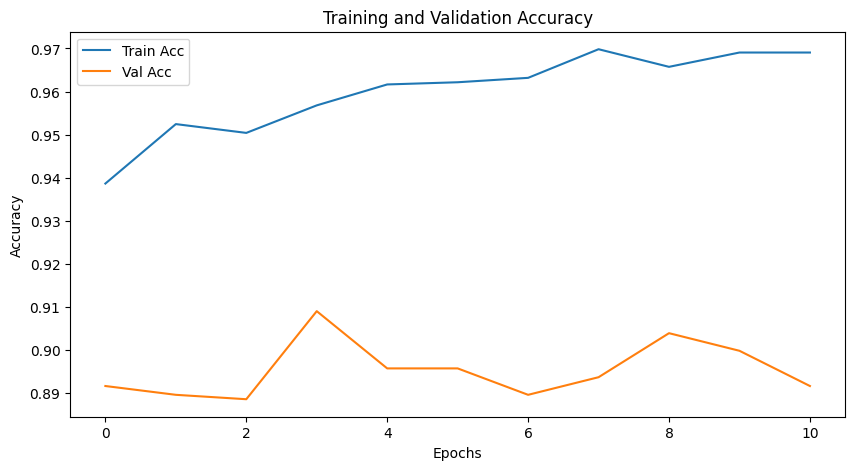

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="Train Loss")
plt.plot(val_losses,label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies,label="Train Acc")
plt.plot(val_accuracies,label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
test_dir = '/content/drive/My Drive/Face_Swap_Detection_Face_Edge_Method/test_data'
# Proceed with testing as before
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        test_running_corrects += torch.sum(preds == labels.data)

test_acc = test_running_corrects.double() / len(test_dataset)
print(f'Test Accuracy: {test_acc:.4f}')


<ipython-input-22-eb4e616464e1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy: 0.9296


In [ ]:
from google.colab import files
files.download('best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Example Testing

Saving ee3b26c2-3d30-48a6-86e5-2d3519f4970d.png to ee3b26c2-3d30-48a6-86e5-2d3519f4970d.png


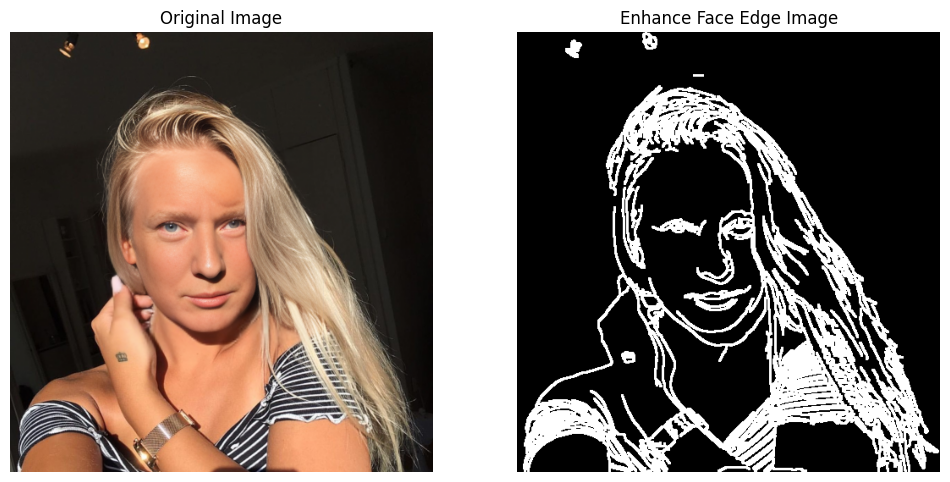

NameError: name 'device' is not defined

In [ ]:
# Step 1: Upload the image
from google.colab import files

uploaded = files.upload()

# Step 2: Import necessary libraries
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms

# Step 3: Define the image processing function
def enhance_face_edge(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

    # Enhance edges (dilate)
    kernel = np.ones((3,3), np.uint8)
    edges_enhanced = cv2.dilate(edges, kernel, iterations=1)

    return img, edges_enhanced

# Step 4: Process the uploaded image
image_filename = next(iter(uploaded))
original_image, processed_image = enhance_face_edge(image_filename)

# Adjust if the processed image is grayscale
if len(processed_image.shape) == 2:
    processed_image_rgb = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2RGB)
else:
    processed_image_rgb = processed_image

# Convert the original image to RGB
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Step 5: Display the images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')

# Processed image
plt.subplot(1, 2, 2)
plt.imshow(processed_image_rgb, cmap='gray')
plt.title('Enhance Face Edge Image')
plt.axis('off')

plt.show()

# Step 6: Preprocess the processed image for the model
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

input_image = transform(processed_image_rgb)
input_batch = input_image.unsqueeze(0).to(device)

# Step 7: Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.load_state_dict(torch.load('best_model.pth', map_location=device))
model = model.to(device)
model.eval()

# Step 8: Make a prediction
with torch.no_grad():
    output = model(input_batch)
    _, predicted = torch.max(output, 1)
    predicted_class = predicted.item()

# Step 9: Interpret and display the prediction
class_names = ['fake', 'real']  # Adjust based on your class mapping
prediction = class_names[predicted_class]

print(f'The model predicts that the image is: {prediction}')

Saving 13e1c6d9-601a-4807-8f35-74b40aa9c347.jpg to 13e1c6d9-601a-4807-8f35-74b40aa9c347 (1).jpg


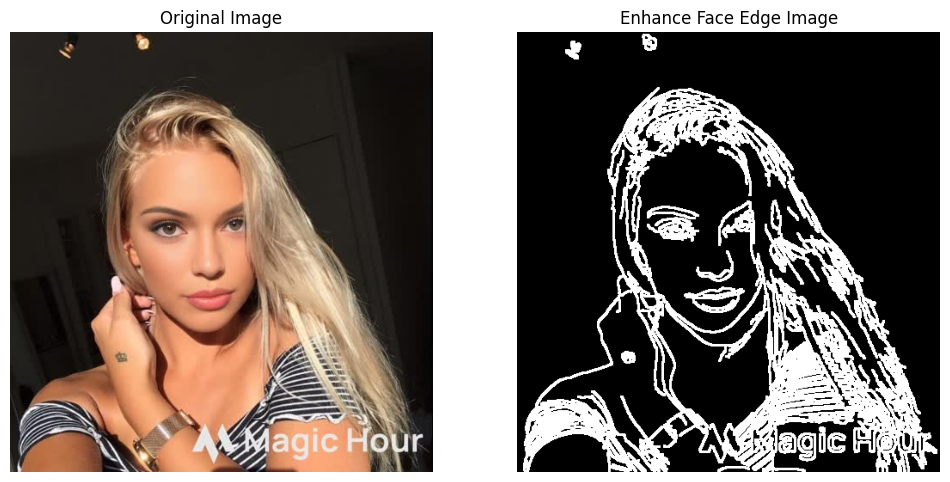

The model predicts that the image is: real


<ipython-input-41-c5accada049c>:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_location=device))


In [ ]:
# Step 1: Upload the image
from google.colab import files

uploaded = files.upload()

# Step 2: Import necessary libraries
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms

# Step 3: Define the image processing function
def enhance_face_edge(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

    # Enhance edges (dilate)
    kernel = np.ones((3,3), np.uint8)
    edges_enhanced = cv2.dilate(edges, kernel, iterations=1)

    return img, edges_enhanced

# Step 4: Process the uploaded image
image_filename = next(iter(uploaded))
original_image, processed_image = enhance_face_edge(image_filename)

# Adjust if the processed image is grayscale
if len(processed_image.shape) == 2:
    processed_image_rgb = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2RGB)
else:
    processed_image_rgb = processed_image

# Convert the original image to RGB
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Step 5: Display the images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')

# Processed image
plt.subplot(1, 2, 2)
plt.imshow(processed_image_rgb, cmap='gray')
plt.title('Enhance Face Edge Image')
plt.axis('off')

plt.show()

# Step 6: Preprocess the processed image for the model
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

input_image = transform(processed_image_rgb)
input_batch = input_image.unsqueeze(0).to(device)

# Step 7: Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.load_state_dict(torch.load('best_model.pth', map_location=device))
model = model.to(device)
model.eval()

# Step 8: Make a prediction
with torch.no_grad():
    output = model(input_batch)
    _, predicted = torch.max(output, 1)
    predicted_class = predicted.item()

# Step 9: Interpret and display the prediction
class_names = ['fake', 'real']  # Adjust based on your class mapping
prediction = class_names[predicted_class]

print(f'The model predicts that the image is: {prediction}')